### Exponential Dispersal Function

&nbsp;

An exponential dispersal function describes the spatiotemporal dispersal of wildlife. The exponential function represents how the density decreases as you move away from its source. The model in this script is listed below.

$$Y = p \times \mathrm{e}^{-\frac{X}{b}}$$

where

Y denotes the probability of dispersal at a distance X from the source

X denotes the distance from the source

p denotes the proportion which does not disperse and stays at the source (X = 0)

b denotes the average dispersal distance

In [1]:
import os
import pandas as pd
from pyproj import Proj
import math
import pyodbc
import itertools
from scipy.optimize import curve_fit
import numpy as np
os.chdir('C:/Users/tm/Downloads/utas/WildlifeDatabases')

### funcs

In [2]:
#gompertz curve equation
def dispersal_func(X,p,b):
    return p*np.exp(-X/b)

#using mle to estimate
def get_func_params(x,y):
    popt,pcov=curve_fit(dispersal_func,x,y,p0=(0.5,np.mean(x)))
    return popt

In [3]:
#coordinates conversion
def convert_easting_northing_to_lat_lon(easting, northing,):
    proj = Proj('+proj=utm +zone=55 +south +ellps=GRS80 +units=m +no_defs')
    lon, lat = proj(easting, northing, inverse=True)
    return lat, lon

#spherical distance computation by chatgpt
def haversine_distance(lat1, lon1, lat2, lon2):
    
    # Convert degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Earth's radius in kilometers
    radius = 6371

    # Difference in latitudes and longitudes
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad

    # Haversine formula
    a = math.sin(delta_lat / 2) ** 2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(delta_lon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Calculate distance
    distance = radius * c

    return distance


### read files

In [4]:
traphist=pd.DataFrame(columns=['ID', 'TrapID', 'DateOfUse', 'Event', 'CaptureType', 'Microchip',
       'Comment'])

traps=pd.DataFrame(columns=['TrapID', 'Northing', 'Easting', 'Comments', 'TrapLine', 'Researcher'])

for i in ['./crabtree/CBT_database_2024_04_CRS.accdb','./franklin/FRA_database_devil_2023_09_CRS.accdb',
         './Woodbridge+Sandfly/Channel_database_devil_2023_11_ER.accdb',
           './arthur river/ARV_database_2023_11_CRES.accdb','./black river/BRI_database_2022_11_KJS.accdb',
         './freycinet/FNP_database_2023_11_CRES.accdb','./takone/TKN_database_2022_12_ACW.accdb',
         './west pencil pine/WPP_Nov_2023_ER.accdb','./wukalina/Wukalina_NOV2020_SN.accdb',
        ]:

    conn = pyodbc.connect(r'Driver={Microsoft Access Driver (*.mdb, *.accdb)};DBQ='+f'{i};')
    traps=pd.concat([traps,pd.read_sql('select * from traps',conn)])
    traphist=pd.concat([traphist,pd.read_sql('select * from traphistory',conn)])
    traps.reset_index(inplace=True,drop=True)
    traphist.reset_index(inplace=True,drop=True)

C:\Users\tm\AppData\Local\Temp\ipykernel_27228\3408298040.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  traps=pd.concat([traps,pd.read_sql('select * from traps',conn)])
C:\Users\tm\AppData\Local\Temp\ipykernel_27228\3408298040.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  traphist=pd.concat([traphist,pd.read_sql('select * from traphistory',conn)])
C:\Users\tm\AppData\Local\Temp\ipykernel_27228\3408298040.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  traps=pd.concat([traps,pd.read_sql('select * from trap

### cleanse

In [5]:
#focus on recapture
traphist=traphist[traphist['Event'].isin(['Tasmanian devil','Tasmanian Devil',])].copy()
target_ids=traphist['Microchip'][traphist['CaptureType']=='Recapture'].unique()
traphist=traphist[traphist['Microchip'].isin(target_ids)]
traps=traps[['TrapID','Northing', 'Easting']].drop_duplicates()

In [6]:
#merge trap info
grande=traphist.merge(traps,on='TrapID',how='left')

#remove duplicates
grande=grande.loc[grande['Northing'].dropna().index]
grande=grande.loc[grande['Microchip'].dropna().index]
grande=grande.drop_duplicates()
grande=grande.sort_values(['Microchip',"DateOfUse"])
grande.reset_index(inplace=True,drop=True)
grande=grande.loc[grande[['DateOfUse','Microchip']].drop_duplicates().index]

In [7]:
#only preserves animals that have been recaptured more than 300 days apart
target_ids=[]
for i in grande['Microchip'].unique():
    subset=grande[grande['Microchip']==i].copy()
    if len(subset)==1:
        continue
    counting=(subset['DateOfUse'].iloc[-1]-subset['DateOfUse'].iloc[0]).days
    if counting<300:
        continue
    target_ids.append(i)
    
#filter microchips
grande=grande[grande['Microchip'].isin(target_ids)]

In [8]:
#cleanse coordinates
grande['Northing']=grande['Northing'].str.replace('5224370.09\r\n5224370.09','5224370.09')
grande['Northing']=grande['Northing'].str.replace('0\r\n0','0')
grande['Northing']=grande['Northing'].astype(float)

grande['Easting']=grande['Easting'].str.replace('605373\r\n605373','605373')
grande['Easting']=grande['Easting'].str.replace('0\r\n0','0')
grande['Easting']=grande['Easting'].astype(float)

C:\Users\tm\AppData\Local\Temp\ipykernel_27228\1487725500.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  grande['Northing']=grande['Northing'].str.replace('5224370.09\r\n5224370.09','5224370.09')


In [9]:
#convert coordinates
grande['lat'],grande['lon']=convert_easting_northing_to_lat_lon(grande['Easting'], grande['Northing'])

In [10]:
#get year and label
grande['year']=grande['DateOfUse'].dt.year

In [11]:
#prepare for trip identification
grande=grande.sort_values('DateOfUse')
grande['dif']=grande['DateOfUse'].diff().apply(lambda x:x.days)
grande.reset_index(inplace=True,drop=True)
grande['cumsum']=grande['dif'].cumsum()

In [12]:
#differentiate each trip
tripnum=0
arr=[]
for i in grande.index:
    if grande['cumsum'].loc[i]<=10:
        arr.append(tripnum)
    else:
        tripnum+=1
        grande['dif'].loc[:i]=0
        grande['cumsum']=grande['dif'].cumsum()
        arr.append(tripnum)
grande['tripnum']=arr

C:\Users\tm\AppData\Local\Temp\ipykernel_27228\315523233.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grande['dif'].loc[:i]=0


In [13]:
#assign trip num for each year
lastyear=1999
lasttrip=1
tripnum=0
arr=[]
for i in grande.index:
    if grande['tripnum'].loc[i]==lasttrip:
        pass
    else:
        lasttrip+=1
        if grande['year'].loc[i]==lastyear:
            tripnum+=1
        else:
            lastyear+=1
            tripnum=0
    arr.append(tripnum)   
grande['year-trip']=arr

In [14]:
#design trip name
grande['trip name']=grande['year'].astype(str)+' trip'+grande['year-trip'].astype(str)

In [15]:
#get first and last date for trip name
triprange=grande.groupby('tripnum').first()['DateOfUse'].astype(str)+' to '+grande.groupby('tripnum').last()['DateOfUse'].astype(str)
mapping=dict(zip(grande['tripnum'].unique(),triprange))
grande['trip range']=grande['tripnum'].apply(lambda x:mapping[x])

### compute X

In [16]:
#compute the distance of annual dispersal
output=pd.DataFrame(columns=['trip id', 'trip range', 'devil id', 'distance','trip coordinates'])
freq=grande.copy()

for i in freq['Microchip'].unique():
    subset=freq[freq['Microchip']==i].copy()
    combs=list(itertools.combinations(subset['DateOfUse'],2))

    #for each trip, only takes the first date of captured
    for ind,val in enumerate(combs):
        dif=(val[1]-val[0]).days
        if dif>330 and dif<390:
            id0=subset['tripnum'][subset['DateOfUse']==val[0]].iloc[0]
            id1=subset['tripnum'][subset['DateOfUse']==val[1]].iloc[0]
            combs[ind]=[str(id0)+'-'+str(id1),val]            
    result=[j for j in combs if type(j)==list]
    
    dataset=pd.DataFrame(result,columns=['trip id','trip range'])
    dataset=dataset.loc[dataset['trip id'].drop_duplicates().index]
    dataset['devil id']=i

    #compute spherical distance
    arr1=[]
    arr2=[]
    arr3=[]
    for k in dataset.index:
        startdate=dataset['trip range'].loc[k][0]
        enddate=dataset['trip range'].loc[k][1]

        lat1=subset['lat'][subset['DateOfUse']==startdate].iloc[0]
        lon1=subset['lon'][subset['DateOfUse']==startdate].iloc[0]
        lat2=subset['lat'][subset['DateOfUse']==enddate].iloc[0]
        lon2=subset['lon'][subset['DateOfUse']==enddate].iloc[0]
        

        arr1.append(haversine_distance(lat1, lon1, lat2, lon2))
        arr2.append((lat1, lon1, lat2, lon2))
    dataset['distance']=arr1
    dataset['trip coordinates']=arr2
    
    output=pd.concat([output,dataset])

output.reset_index(inplace=True,drop=True)

In [22]:
#remove coordinates error
output=output[output['distance']<50]

### compute Y

In [23]:
#group distance for probability computation
output['round dist']=output['distance'].apply(lambda x:round(x,0))

In [24]:
#compute the probability of distance
prob=output.groupby(['round dist']).count()[['trip id']]
prob['trip id']=prob['trip id']/prob['trip id'].sum()
prob.columns=['prob']
prob.reset_index(inplace=True)

In [25]:
#merge
output=output.merge(prob,on='round dist',how='left')

In [26]:
#convert km to m
output['distance']*=1000

In [27]:
#get grid distance
#grid is 10km by 10km
#but the center to the edge is around 5
#any distance beyond 5 in considered stepping into a new grid
output['grid dist']=output['distance']//5000

In [28]:
#compute the probability of grid distance
prob=output.groupby(['grid dist']).count()[['trip id']]
prob['trip id']=prob['trip id']/prob['trip id'].sum()
prob.columns=['grid prob']
prob.reset_index(inplace=True)

In [29]:
#merge
output=output.merge(prob,on='grid dist',how='left')

### estimate

In [30]:
#result
portion,breath=get_func_params(output['distance'].tolist(),output['prob'].tolist())
print(portion)
print(breath)

0.19627642635269832
5787.871125983102


In [31]:
min(output['distance']),max(output['distance'])

(0.0, 36276.774753351325)

In [32]:
get_func_params(output['grid dist'].tolist(),output['grid prob'].tolist())

array([0.77586645, 0.57164167])

### fit distribution

In [33]:
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module='scipy.stats')
warnings.filterwarnings("ignore", category=RuntimeWarning, module='scipy.optimize')

def fit_distributions(data):
    
    distributions = [
        stats.cauchy,
        stats.truncnorm,
        stats.genexpon,
        stats.genpareto,
        stats.dweibull,
        stats.pearson3,
        stats.norm,        
        stats.laplace,       
        stats.triang,       
        stats.weibull_min,  
        stats.gumbel_r,
        stats.gumbel_l,
        stats.pareto,
        stats.skewnorm,
        stats.t,
        stats.exponpow,
        stats.expon,
        stats.gamma,
        stats.lognorm,
        stats.chi2,
        stats.binom,
        stats.poisson,
        stats.geom,
        stats.logistic,
        stats.johnsonsu,
        stats.beta,
        stats.powerlaw,
    ]
    
    
    results = []
    
    for dist in distributions:
        
        try:
            # Fit the distribution to the data
            params = dist.fit(data)
            
            # Calculate the CDF for the fitted distribution
            cdf_fitted = dist.cdf(data, *params)
            
            # Calculate the empirical CDF of the data
            sorted_data = np.sort(data)
            cdf_empirical = np.arange(1, len(data) + 1) / len(data)
            
            # Compute Mean Squared Error between empirical and fitted CDF
            mse = mean_squared_error(cdf_empirical, dist.cdf(sorted_data, *params))
            
            results.append({
                'distribution': dist.name,
                'params': params,
                'mse': mse
            })
        except Exception as e:
            print(f"Could not fit distribution {dist.name}: {e}")
            continue
            
    # Convert results to DataFrame for easy comparison
    results_df = pd.DataFrame(results)

    # Find the distribution with the lowest MSE
    best_fit = results_df.loc[results_df['mse'].idxmin()]
    
    return best_fit, results_df

In [34]:
#get best dist based on mse
best_fit, results_df = fit_distributions(output['distance']*10)
results_df=results_df.sort_values('mse')

C:\Users\tm\AppData\Local\anaconda3\envs\ame\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\tm\AppData\Local\anaconda3\envs\ame\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Could not fit distribution binom: 'binom_gen' object has no attribute 'fit'
Could not fit distribution poisson: 'poisson_gen' object has no attribute 'fit'
Could not fit distribution geom: 'geom_gen' object has no attribute 'fit'


In [35]:
#find the best dist
results_df

,distribution,params,mse
9,weibull_min,"(0.925261323146114, 627.0470158876225, 36388.3...",0.000975
21,johnsonsu,"(-5.455901312160113, 0.8902803233042046, -2642...",0.001116
5,pearson3,"(2.2479789925377816, 34670.22272516539, 38968....",0.001150
2,genexpon,"(2.131916539395821, 1.860181948319397, 0.00036...",0.001654
16,expon,"(0.0, 39054.16347645496)",0.001672
10,gumbel_r,"(21310.36170601671, 25522.753010403558)",0.003471
14,t,"(1.7427274307084795, 23090.9590852147, 18610.5...",0.004158
7,laplace,"(24423.366579328358, 28996.439131572213)",0.004430
4,dweibull,"(0.8807894375913699, 23266.31643739451, 26983....",0.004673
20,logistic,"(30129.07988010907, 21208.13821840213)",0.004909


In [36]:
#use weibull minimum
a,b,c=stats.weibull_min.fit(output['distance'])

In [37]:
#get histogram
y,x=np.histogram(output['distance'], bins=100)

#convert freq to probability
y=y/y.sum()

In [38]:
#get in between mean rather than bin value
x1=x[:-1]
x2=x[1:]
x=(x1+x2)/2

In [39]:
#compute probability from weibull minimum
y_test=np.array([stats.weibull_min(a,b,c).pdf(i) for i in x])
y_test=y_test/y_test.sum()

In [40]:
#compute exponential distance probability
y_fitted=np.array([portion*np.exp(-i/breath) for i in x])
y_fitted=y_fitted/y_fitted.sum()

Text(0, 0.5, 'probability')

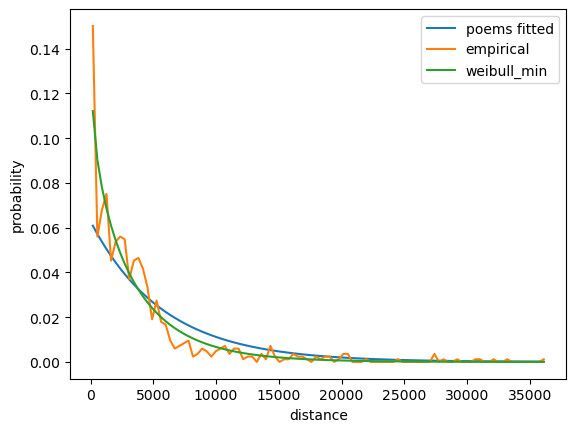

In [41]:
plt.plot(x,y_fitted,label='poems fitted')
plt.plot(x,y,label='empirical')
plt.plot(x,y_test,label='weibull_min')
plt.legend()
plt.xlabel('distance')
plt.ylabel('probability')

In [54]:
stats.weibull_min(a,b,c).cdf(25000)-stats.weibull_min(a,b,c).cdf(15000)

0.02223315978765572

In [53]:
stats.weibull_min(a,b,c).cdf(15000)-stats.weibull_min(a,b,c).cdf(5000)

0.24059731751852453

In [52]:
stats.weibull_min(a,b,c).cdf(5000)

0.7345237946531971

In [42]:
sad

NameError: name 'sad' is not defined

In [ ]:
A